# A Very Brief Look of Variational Autoencoders

## Summary
This notebook describes and implements a Variational Autoencoder (VAE) in pytorch. VAEs are a type of generative model. By providing a dataset, a variational autoencoder uses variational Bayesian methods to generate similar examples. Once trained, it can be used to turn noise into images.

These notes are based off this [VAE tutorial](https://arxiv.org/abs/1606.05908) and the explanation provided in [these notes](https://deepgenerativemodels.github.io/notes/vae/). The target audience for this notebook is someone who has read about VAEs but wanted to see another explanation and an implementation. Further reading is provided below. If you are just interested in the implementation, you can skip the first half of this notebook.

Finally, it should be known that $\simeq$ is used below to denote that two values are equal up to a constant difference. Specifically, if $a \simeq b$, then $a = b + \text{constant}$. This is used as constants are ignored during optimization. The symbol $\approx$ still means approximately equal, though.

## Training Objective
Suppose we have a set of observations $D = \{x_1, \dots, x_N\}$. We want to generate examples similar to the observations in $D$, but how do we start? One approach is to find a probability distribution $p$ such that $p(x)$ is high for $x$ similar to an observation in $D$, and low for dissimilar observations. However, if the observations are high dimensional, then the dependencies between dimensions can be complex. Untangling these dependencies can make finding $p$ difficult. To alleviate this, we can introduce a latent variable.

A latent variable is a variable that is inferred from the observation. In the right situations, it encodes high level information that can be used to recreate the observation. Introducing this latent variable means that we are now looking for $p(x, z)$, where $z$ is our latent variable. We can break down this distribution into $p(x|z)p_\ell(z)$. The benefit is that this gives us a generative process: we can first generate a $z$ according to $p_\ell$ and then use $p(x|z)$ to generate an $x$.

At this point, we can always recover $p(x)$ using integration as we have

$$p(x) = \int_\mathcal{Z} p(x|z)p_\ell(z)dz,$$

where $\mathcal{Z}$ is the space of all possible latent variables. However, this integral is generally intractable. This difficulty is important as our goal is to make $p$ similar to $p_D$. Instead of optimizing $p$ directly, we will use variational Bayesian methods.

Variational Bayesian methods are aimed at approximation the posterior. We are attempting to approximate $p(z|x)$ with another distribution $q_\lambda(z)$, where $\lambda = \lambda(x)$. We are forced to use an approximation as $p(z|x)$ is just as difficult to evaluate as $p(x)$. However, if we had the posterior $p(z|x)$, then we could find $p(x)$ using 

$$p(x) = \frac{p(x, z)}{p(z|x)} \approx \frac{p(x, z)}{q_\lambda(z)}.$$

The benefit of introducing this is that we now have

$$\log p(x) 
\geq \int_\mathcal{Z} q_\lambda(z) \log\left(\frac{p(x, z)}{q_\lambda(z)}\right) dz
= \mathbb{E}_{q_\lambda}\left[\log(p(x, z)) - \log(q_\lambda(z))\right].$$

This lower bound (called the Evidence Lower Bound, or ELBO) is possible to approximate with an unbiased Monte Carlo estimator when $q$ is simple to sample from. (Big note: this estimate uses Jensen's inequality. See either tutorial above for a derivation.)

## Variational Autoencoders
### The probabilistic model
Variational autoencoders are a type of latent variable model where we use a network to learn the distributions. The basic variational autoencoder was defined with specific distribution choices.

The latent distribution $p_\ell$ is chosen to be the standard normal $N(0, I)$. In this situation, we do not optimize over $p_\ell$ as it does not change. Implicit in this is that our latent variables are normally distributed.

The posterior $q_\lambda$ is a normal distribution. That is, $\lambda(x) = (\mu(x), \Sigma(x))$ and $q_\lambda = N(\mu(x), \Sigma(x))$. Generally $\Sigma$ is restricted to be diagonal. This results in a factorized Gaussian (where each dimension is statistically independent). In this case, if $\Sigma_{ii} = \sigma_i^2$ (so that $\sigma_i$ is the scale in the $i$th coordinate), then we specifically have

$$-\log q(z|x, \theta) 
\simeq \sum_i \left(\frac{(x-\mu_i)^2}{2\sigma_i^2}+\log \sigma_i\right).$$

The distribution $p(x|z)$ is typically chosen to be either a normal distribution or a Bernoulli distribution, depending on the target data. We will use $x \sim N(\mu(z), I)$, so that we have that

$$-\log p(x|z) \simeq \tfrac{1}{2}\Vert x-\mu(z) \Vert^2_2,$$

which is a multiple of the mean squared error.

### The network
To turn this into a variational autoencoder, we need to introduce some networks. In this situation, that means we use a network to learn the parameters for the distributions $p(x|z)$ and $q_\lambda(z)$. In practice, we separate this into two modules that are both parameterized by $\theta$.

The first is the encoder $f_\theta$. The encoder takes an observation $x$ and outputs statistical parameters used to determine the latent variable. This is done using

$$f_\theta(x) = \lambda(x) = (\mu_\theta(x), \Sigma_\theta(x)).$$

These parameters are then used for $q_\lambda(z)$. An important note is that if we draw $z \sim q_\lambda$, then we have no way to recover the parameters $\lambda$ for back propogation. To avoid this, we use the 'reparamiterization trick' and define $z$ as a transformation of a random variable. This means we draw $\epsilon \sim N(0, I)$ and let $z = \mu+\Sigma^{1/2}\epsilon$, where $\Sigma^{1/2}$ is the Choletsky factorization of $\Sigma$ (effectively giving us a square root of the matrix). This is equivalent to sampling from $N(\mu, \Sigma)$ but allows us to differentiate $z$ (w.r.t. $\theta$). The variable $\epsilon$ can be used in our log probability to instead give us

$$\log q_\lambda(z) \simeq -\sum_i \left(\tfrac{1}{2}\epsilon_i^2+\log \sigma_i\right).$$

The second module is the decoder $g_\theta$. The decoder turns a latent variable $z$ and outputs the statistical parameter $\mu(z)$. More explicitely, we now have that

$$-\log p(x|z) \simeq \tfrac{1}{2}\Vert x-g_\theta(z) \Vert^2_2.$$

### Final form of the loss function
With the choices above, we are now ready to write our loss function. We are trying to maximize $\log p(x)$ for $x \in D$. As Torch works by minimizing, this means we are going to instead minimize $-\log p(x)$. We then replace this with the evidence lower bound to change goals to minimizing $-\mathbb{E}_{q_\lambda}\left[\log(p(x, z)) - \log(q_{\lambda}(z))\right]$. If we expand the first term in the expectation, we have

$$-\log p(x, z) 
= -\log (p(x|z)p_\ell(z)) 
= - \log p(x|z) - \log p_\ell(z) 
\simeq \tfrac{1}{2}\Vert x-g_\theta(z) \Vert^2_2+\tfrac{1}{2}\Vert z \Vert^2_2.$$

This gives us a final loss function of 
$$-\mathbb{E}_{q_\lambda}\left[\log(p(x, z)) - \log(q_\lambda(z))\right]
= \mathbb{E}_{q_\lambda}\left[\log(q_\lambda(z))-\log(p(x, z))\right] 
= \mathbb{E}_{q_\lambda}\left[\tfrac{1}{2}\Vert x-g_\theta(z) \Vert^2_2 + \tfrac{1}{2}\Vert z \Vert^2_2 -\sum_i \left(\tfrac{1}{2}\epsilon_i^2+\log \sigma_i\right)\right].$$

We compute this last quantity using Monte Carlo methods, meaning we approximate it by using a number of samples.

It's worth noting what exactly we are getting when we optimize using this bound. The $\epsilon$ term can be ignored, as it's not subject to our parameters. The first term, $\Vert x - g_\theta(z) \Vert^2_2$, is optimized by choosing parameters for the decoder that produce accurate reconstructions. The term $\Vert z \Vert^2_2$ is optimized by making the latent variable small; this is most directly done by decreasing the mean. The final term, $-\sum_i \log \sigma_i$, has more flexibility as it's able to take both positive and negative values. If $\sigma_i$ is small, then $z$ has little variance, but $-\log\sigma_i$ will be large. On the other hand, if $\sigma_i$ is large, then $z$ has a lot of variance (which makes the decoder's job harder) but $-\log\sigma_i$ is now a negative value. In essence, the scale parameter can reduce the loss if chosen to be large, but this is only feasible if the decoder can still make accurate representations. Meanwhile, the entire expectation can be made smaller by adjusting $q_\lambda$.

#### Alternate loss function
An alternate choice for lower bound uses the [Kullback-Leibler (KL) divergence](http://mathworld.wolfram.com/Kullback-LeiblerDistance.html), $\text{KL}(q||p_\ell)$. With $q_\lambda$ and $p_\ell$ as chosen above, the divergence term can be computed analytically as

$$\text{KL}(q_\lambda || p_\ell) \simeq \tfrac{1}{2}\sum_i (\sigma_i^2 + \mu_i^2 - \log \sigma_i^2 - 1).$$

Using this with a variant evidence lower bound, we have

$$-\log p(x)
\leq -\mathbb{E}_{q_\lambda}\left[\log(p(x|z))\right] + \text{KL}(q_\lambda||p_\ell) 
\simeq \mathbb{E}_{q_\lambda}\left[\tfrac{1}{2}\Vert x - g_\theta(z) \Vert^2_2 \right] + \tfrac{1}{2}\sum_i (\sigma_i^2 + \mu_i^2 - \log \sigma_i^2 - 1).$$

While this form of loss can be useful, it turns out that the KL loss is too restrictive in some cases. Specifically, we have that if $q_\lambda(z) = p(z|x)$, then the Monte Carlo loss above will be $0$, but the KL loss here will still have a constant entropy. Thus, the Monte Carlo error above should be used if we suspect that we can learn $\lambda$ well enough that $q_\lambda(z) \approx p(z|x)$. This is explained in [Sticking the Landing](https://arxiv.org/abs/1703.09194) by Roeder et al, which also notes that the MC form is easier to apply when using normalizing flows.

Similar to above, the result of optimization on the individual components can be interpreted for this loss. The new term, the KL divergence, is minimized when $q_\lambda$ has the same distribution $p_\ell$. Thus, the KL term pushes the posterior distribution towards being like the latent distribution. It's worth noting that this is not necessarily desirable, as $q_\lambda$ is supposed to approximate $p(z|x)$.

## Code

Below is the code for the network. You can run it in the notebook with (probably) few modifications needed. You can also copy the code into a python file. The necessary packages are pytorch, torchvision for the computations, and matplotlib for the plots.

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

### Layers
#### Statistics Layer

The statistics layer outputs the mean and scale (i.e. standard deviation) that will be used to generate the latent variables. It returns the latent variable and the associated loss. Below both the KL and fully Monte Carlo loss are included.

In [2]:
class LatentLayer(nn.Module):
    '''
    Creates a layer that takes an input and outputs latent parameters.
    :param input_size: (int) Size of input
    :param latent_size: (int) Number of latent dimensions
    '''
    def __init__(self, input_size, latent_size):
        super(LatentLayer, self).__init__()
        self.mean = nn.Linear(input_size, latent_size)
        self.variance = nn.Linear(input_size, latent_size)

    def forward(self, input):
        '''
        Encodes input to the latent statistics.
        :param input: (t.Tensor)
        :return: (t.Tensor, t.Tensor) Statistical parameters
        '''
        mean = self.mean(input)
        log_var = self.variance(input)
        scale = (log_var/2).exp()
        return mean, scale

#### VAE Class

This implements the VAE network. It's made up of two separate modules: an encoder network, and a decoder network.

In [3]:
class VAE(nn.Module):
    '''
    Creates a Variation Autoencoder
    
    :param encoder_network: (nn.Module)
    :param decoder_network: (nn.Module)
    :param loss: (str, opt) Either 'kl' or 'mc'. Sets how to calculate loss.
    '''
    def __init__(self, encoder_network, decoder_network, loss='mc'):
        super(VAE, self).__init__()
        
        self.add_module('encode', encoder_network)
        self.add_module('generate', decoder_network)
        self.loss = loss.lower()
        
    def forward(self, input):
        '''
        Passes forward through encoder to create a sample latent
        representation, then decodes that representation.
        
        :param input: (t.Tensor) 
        :return: (t.Tensor) Reconstruction of x and it's latent loss
        '''
        mean, scale = self.encode(input)
        eps = t.randn_like(mean)
        z = mean+scale*eps
        if self.training:
            if self.loss == 'mc':
                loss = self.MC(z, eps, scale)
            elif self.loss == 'kl':
                loss = -self.KL(mean, scale)
        else:
            loss = t.tensor(0)
        
        return self.generate(z), loss

    def generate_similar(self, input, noise=True):
        '''
        Creates similar examples by encoding the observation and then decoding the 
        latent observation. If noise is True, then it uses the latent variable
        z = mean+eps*scale. Otherwise, z = mean.

        :param input: (t.Tensor)
        :param noise: (Bool, opt)
        :return: (torch.Tensor) Reconstruction of input
        '''
        mean, scale = self.encode(input)

        if noise:
            eps = t.randn_like(mean)
            z = mean+scale*eps
        else:
            z = mean

        return self.generate(z)
    
    @staticmethod
    def KL(mean, scale):
        '''
        Computes the KL divergence of a normal distribution with the parameters above
        from N(0, 1) on a batch and then returns the mean.

        :param means: (torch.Tensor)
        :param scale: (torch.Tensor)
        :return: The KL divergence
        '''
        variance = scale.pow(2)
        loss = t.sum(variance+means.pow(2)-t.log(variance)-1, 1)/2.
        #Return batch average
        return loss.mean()
    
    @staticmethod
    def MC(z, eps, scale):
        '''
        Computes fully monte carlo loss for the statistics layer.
        
        :param z: (t.Tensor) latent variable
        :param eps: (t.Tensor) random noise
        :param scale: (t.Tensor) scale (or standard deviation)
        '''     
        loss = t.sum(z.pow(2)/2-(eps.pow(2)/2+scale.log()), 1)
        return loss.mean()

#### Utility layer
This layer reshapes the input. This is done for convenience when using `nn.Sequential`.

In [4]:
class ReshapeLayer(nn.Module):
    '''
    Reshapes the input to be the output using view. Shapes are checked
    on forward pass to verify that they are compatible.

    :param view_shape: The shape to cast the input to. Given a batch
        input of shape (n, _) will be cast to (n, view_shape).
    '''
    def __init__(self, view_shape):
        super(ReshapeLayer, self).__init__()
        self.view_shape = view_shape

    def forward(self, x):
        '''
        Reshapes x to initialized shape.
        :param x: (t.Tensor)
        :return: (t.Tensor)
        '''
        output_shape = (x.shape[0],) + self.view_shape
        assert self.dimension(x.shape) == self.dimension(output_shape), \
            '{0} and {1} are not compatabile'.format(x.shape, output_shape)
        return x.view(output_shape)

    @staticmethod
    def dimension(shape):
        #Helper function for checking dimensions
        out = 1
        for s in shape:
            out *= s
        return out

### Building the network

Here we build the encoder and decoder. This is done using the Sequential function. The encoder network needs to end with the statistics layer. The decoder is just a standard decoder. The size of the hidden layers are chosen experimentally.

Each network uses SELU activation functions. These are Scaled ELU activations. SELU activations are similar to ELU activations, but are supposed to have regularizating effects on the network as described in [self normalizing neural networks](https://arxiv.org/abs/1706.02515). I included them for experimentation purposes. Other typical choices for activation functions are ELU and RELU activation functions.

In [5]:
latent_dim = 32

#Build networks
encoder_net = nn.Sequential(
    ReshapeLayer((28**2,)),
    nn.Linear(28**2, 256),
    nn.SELU(),
    nn.Linear(256, 256),
    nn.SELU(),
    LatentLayer(256, latent_dim)
)

decoder_net = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.SELU(),
    nn.Linear(256, 256),
    nn.SELU(),
    nn.Linear(256, 28**2),
    nn.Sigmoid(),
    ReshapeLayer((1, 28, 28)),
)

model = VAE(encoder_net, decoder_net)

### Dataset

For this notebook, we use the MNIST dataset. A drop-in replacement that can be used is the FashionMNIST dataset.

In [6]:
import torch.utils.data as data
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

In [7]:
training_set = datasets.MNIST(root='./', train=True, download=False, transform=ToTensor())
batch_size = 500
training_loader = data.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)

### Optimizing the network parameters

Now that we have the network, we need to find parameters that minimizes our estimate above. In order to accomplish this, we run the model over a batch of observations, and then compute the loss. Using stochastic gradient descent methods, we can then find a change of parameters that will (usually) decrease the loss.

More explicitely, the encoder network takes in an observation $x$ and produces statistics, $(\mu, \Sigma)$, for the latent variable, $z$. Using the Monte Carlo loss or KL divergence above, we can determine a loss for the encoder. We then use $z$ to generate a reconstruction of the observation, $\hat{x}$. By comparing $x$ and $\hat{x}$, we have a loss for the decoder. The total loss of the variational autoencoder is the sum of these two losses. Because we are minimizing the sum, there is no guarantee that both components will decrease. In fact, the encoder loss typically increases while the decoder loss typically decreases. This is seen in the training summary printed below.

In [8]:
def mse_loss(input, target):
    loss = (input-target).pow(2)/2
    #Return batch average
    return loss.mean(0).sum()

In [9]:
def train_vae(model, data_loader, optimizer, use_gpu=True):
    average_recon = 0
    average_latent = 0
    for n_batch, (x, _) in enumerate(data_loader):
        if use_gpu:
            x = x.cuda()
        
        x_pred, latent_loss = model(x)
        
        #compute -log p(x|z)
        recon_loss = mse_loss(x, x_pred)
        loss = recon_loss+latent_loss
        
        #Compute average
        average_latent += (latent_loss-average_latent)/(n_batch+1)
        average_recon += (recon_loss-average_recon)/(n_batch+1)

        #Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Print percent complete
        print(percent_complete.format(batch_size*n_batch/n_data), end='')
        
    return average_recon, average_latent

In [10]:
epochs = 50
use_gpu = True
model.train()

#Add to gpu before making the optimizer
if use_gpu:
    model.cuda(0)

optimizer = t.optim.AdamW(model.parameters())

epoch_summary_text = '\rEpoch {0}/{1}'
loss_summary_text = '{0} loss: {1:.5}'

percent_complete = '\r{0:.1%}'

n_data = len(training_set)
for epoch in range(epochs):
    recon_loss, latent_loss = train_vae(model, training_loader, optimizer, use_gpu)

    #Create summary loss
    epoch_summary = epoch_summary_text.format(epoch+1, epochs)
    latent_summary = loss_summary_text.format('latent', latent_loss)
    recon_summary = loss_summary_text.format('recon', recon_loss)
    total_summary = loss_summary_text.format('total', latent_loss+recon_loss)
    print(epoch_summary, recon_summary, latent_summary, total_summary, sep=' - ')
    
t.save(model.state_dict(), './models/vae.pkl')

Epoch 1/50 - recon loss: 29.924 - latent loss: 1.6901 - total loss: 31.614
Epoch 2/50 - recon loss: 22.796 - latent loss: 1.8064 - total loss: 24.602
Epoch 3/50 - recon loss: 19.465 - latent loss: 3.3357 - total loss: 22.8
Epoch 4/50 - recon loss: 17.766 - latent loss: 4.0523 - total loss: 21.818
Epoch 5/50 - recon loss: 16.841 - latent loss: 4.4483 - total loss: 21.289
Epoch 6/50 - recon loss: 16.221 - latent loss: 4.7136 - total loss: 20.934
Epoch 7/50 - recon loss: 15.727 - latent loss: 4.9466 - total loss: 20.674
Epoch 8/50 - recon loss: 15.379 - latent loss: 5.0935 - total loss: 20.472
Epoch 9/50 - recon loss: 15.147 - latent loss: 5.199 - total loss: 20.346
Epoch 10/50 - recon loss: 14.947 - latent loss: 5.2806 - total loss: 20.227
Epoch 11/50 - recon loss: 14.775 - latent loss: 5.349 - total loss: 20.124
Epoch 12/50 - recon loss: 14.642 - latent loss: 5.3988 - total loss: 20.041
Epoch 13/50 - recon loss: 14.499 - latent loss: 5.4549 - total loss: 19.954
Epoch 14/50 - recon loss:

## Examples

### Image Reconstruction

Variational autoencoders can be used to reconstruct observations. This is exactly the training process: we encode the observation to a latent variable, and then use the latent variable to generate an image. After training, the network should be able to reconstruct both the example and similar examples. This is shown below. The images in the top row are the originals, while the images below are the reconstructions. The second row is a reconstruction using the mean, while the lower rows show what would be typically generated during training.

The reconstructions are noticeably blurry. This is a fairly common issue with simple VAE models. There are a number of ways to improve the quality of the generated pictures. A few of these are mentioned below.

In [11]:
import matplotlib.pylab as plt
from random import sample

def image_plot(axis, image, **kwargs):
    axis.imshow(image.view(28,28), cmap='Greys', **kwargs)

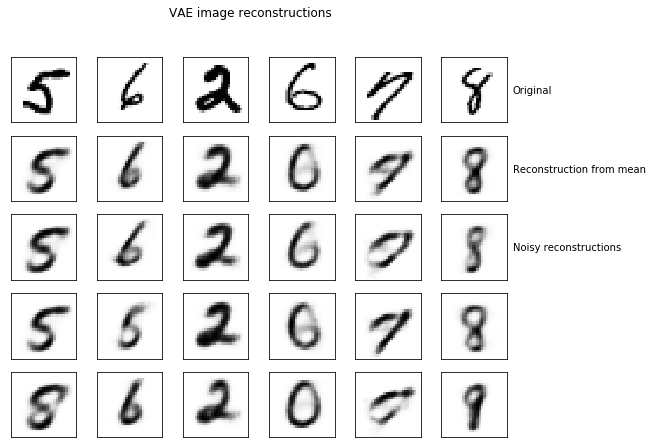

In [12]:
#Set up picture
n_images = 6
ax_settings = {'aspect':'equal', 'xticklabels':[], 'yticklabels':[], 'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(5, n_images, subplot_kw=ax_settings, figsize=(9, 7))


model.cpu()
model.eval()
with t.no_grad():
    data_sample = next(iter(training_loader))
    images, _ = data_sample
    images = images[:n_images]
    #Create most likely example (i.e. using the mean)
    recons = model.generate_similar(images, noise=False)
    for idx in range(n_images):
        image_plot(ax[0, idx], images[idx,:])
        image_plot(ax[1, idx], recons[idx,:])
        
    #Create similar examples with noise
    for row in range(2, 5):
        recons = model.generate_similar(images)
        for idx in range(n_images):
            image_plot(ax[row, idx], recons[idx,:])
            
fig.suptitle('VAE image reconstructions')
ax[0,-1].text(30, 15, 'Original')
ax[1,-1].text(30, 15, 'Reconstruction from mean')
ax[2,-1].text(30, 15, 'Noisy reconstructions')
plt.savefig('./images/MNIST-VAE-reconstructions.png', bbox_inches='tight')

### Image generation using latent sampling

My interest in VAE are mostly tied to the fact that you can use them to generate new images. One of the original assumptions we made at the onset of our model is that $p_\ell$ is normally distributed. Thus, we can generate $z$ by drawing from a standard normal distribution $N(0, I)$ and then decode that generated latent variable to form an observation. This is what we see below.

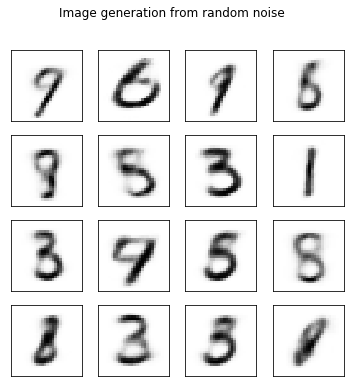

In [13]:
fig, ax = plt.subplots(4, 4, subplot_kw=ax_settings, figsize=(6, 6))

with t.no_grad():
    latent_sample = t.randn(16, latent_dim)
    images = model.generate(latent_sample)
    ax = ax.flatten()
    for idx in range(16):
        image_plot(ax[idx], images[idx])

fig.suptitle('Image generation from random noise')
plt.savefig('./images/MNIST-VAE-latent_samples.png')

## Further Reading

If you are interested in learning more about variational autoencoders, here is what I recommend:
* [Towards a deeper understanding of VAEs](https://arxiv.org/abs/1702.08658v1), which explains in part why the blurry images above occur. I had originally believed it was a result of using an inappropriate loss function, but it turns out that this is actually caused by the decoder using the average reconstruction. In our notation, this means the decoder is learning to return $\mathbb{E}_{p(x|z)}[x]$. The paper also discuss how to avoid blurry images.
* [Improved Variational Inference with Inverse Autoregressive Flow](https://arxiv.org/abs/1606.04934v2), which describes how to encode to non-diagonal $\Sigma(x)$ in a computationally straight-forward way. Another approach based on this paper is offered in [convex combination linear Inverse Autoregressive Flow](https://arxiv.org/abs/1706.0232), which is more easily applied.
* It's also worth pointing out that you can use *several* latent variables. There are two variants I'm aware of for this: the Ladder Variational Autoencoder and the Variational Ladder Autoencoder.

## Final Comments

I made this notebook to have an easy way of sharing my interest in VAEs with others. If you find an error or have any suggestions, please let me know.